In [4]:
import gym

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model 
import numpy as np
from collections import deque
from sklearn.utils import shuffle
import copy

Using TensorFlow backend.


In [4]:
!pip install box2d

In [6]:
class EpsDecisionMaking():
    def __init__(self, eps, min_eps, eps_decay, n_jumps):
        self.start_eps = eps
        self.eps = eps
        self.min_eps = min_eps
        self.eps_delta = eps_decay
        self.n_jumps = n_jumps
    
            
class QLearningMethod():
    def __init__(self, gamma, learning_rate, batch_size, max_memory_len, n_actions, n_states, eps_settings, tau, mode='train'):
        self.gamma = gamma #параметр, с помощью которого задается баланс между сиюминутными наградами и будущими
        self.n_actions = n_actions #количество возможных действий
        self.n_states = n_states #количество степеней свободы
        self.learning_rate = learning_rate
        self.memory = None # шаги агента. (состояние_t, действие_t, награда_t, состояние_t+1, выполнен ли эпизод?)
        self.max_memory_len = max_memory_len #максимальная длина шагов, которых модель способна запомнить
        self.batch_size = batch_size
        self.mode = mode
        self.tau = tau #интенсивность передачи информации от local_model к target_model
        for key, param in eps_settings.items():
            setattr(self, key, param)
        if self.mode=='train':
            self.local_model = self.get_QNN() #сама модель
            self.target_model = self.get_QNN()
        else:
            self.local_model = self.load_QNN() #обученная модель
        self.n_layers = len(self.local_model.layers)
        
    def soft_update(self):
        #метод, реализующий передачу информации от local_model к target_model
        for layer_index in range(self.n_layers):
            local_params = self.local_model.get_layer(index = layer_index).get_weights()
            target_params = self.target_model.get_layer(index = layer_index).get_weights()
            weighted_res = []
            for local_nparray, target_nparray in zip(local_params, target_params):
                weighted_res.append(self.tau*local_nparray + (1-self.tau)*target_nparray)
            self.target_model.get_layer(index = layer_index).set_weights(weighted_res)
            
    def get_QNN(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.n_states, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.n_actions, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    def random_choice(self):
        #если этот метод не вернул None, то агентом делается случайный выбор
        rand = np.random.random()
        if rand >= 1 - self.eps:
            self.minimize_eps()
            return np.random.choice(range(self.n_actions))
        self.minimize_eps()
        return None
    
    def minimize_eps(self):
        #метод скачкообразно снижающий эпсилон, надо сказать, что он его снижает очень быстро
        self.eps = self.eps*self.eps_delta
        if self.eps < self.min_eps and self.n_jumps > 0:
            self.eps = copy.deepcopy(self.max_eps)
            self.n_jumps -= 1
        elif self.eps < self.min_eps:
            self.eps = copy.deepcopy(self.min_eps)
            
    def load_QNN(self):
        return load_model('./saved_models/short_memory_smart_agent_local.h5')
            
    def choose_action(self, curr_state):
        #метод, выбирающий действия, именно он важен в обученном агенте. Когда агент обучился, я выключаю рандом
        if self.mode=='train':
            choice = self.random_choice()
            if choice is not None:
                return choice
        curr_state = np.reshape(curr_state, [1, self.n_states])
        real_Qvalues = self.local_model.predict(curr_state)
        return np.argmax(real_Qvalues[0])
    
    def remember_step(self,curr_state, curr_action, curr_reward, next_state, done):
        #запомнить шаг
        what2add = np.array([curr_state, curr_action, curr_reward, next_state, done])
        if self.memory is None:
            self.memory = what2add
        else:
            if self.memory.shape[0]==self.max_memory_len:
                self.memory = np.delete(self.memory, 0, axis=0)
            self.memory = np.vstack((self.memory, what2add))
    def faster_expirience_reply(self):
        #метод, делающий абсолютно то же самое, что и expirience_reply, только быстрее, так как реализован на numpy векторах
        batch = shuffle(self.memory)[-self.batch_size:]
        states = np.vstack(batch[:, 0])
        real_Qvalues = self.local_model.predict(states)
        non_terminal = batch[:,4]==False
        non_terminal_indexes = np.array(np.nonzero(non_terminal)).flatten()
        terminal_indexes = np.array(np.nonzero(~non_terminal)).flatten()
        wanted_Qvalues = batch[non_terminal, 2] + self.gamma * np.amax(self.target_model.predict(np.vstack(batch[non_terminal, 3])), axis = -1)
        
        real_Qvalues[non_terminal_indexes, batch[non_terminal_indexes, 1].flatten().astype(np.int64)] = wanted_Qvalues
        real_Qvalues[terminal_indexes, batch[terminal_indexes, 1].flatten().astype(np.int64)] = batch[terminal_indexes, 2]
        self.local_model.fit(states, real_Qvalues, batch_size=self.batch_size, epochs=1, verbose=0) 
        self.soft_update()
    def expirience_reply(self):
        states = [] #то, что мы должны подать на вход модели: координаты в пространстве
        Qvalues = [] #модель должна выдать полезности всех возможных действий

        batch = shuffle(self.memory)[-self.batch_size:] #рандомно мешаем информацию в батчах и достаем самые последние элементы в колв-ве batch_size
        for curr_state, curr_action, curr_reward, next_state, done in batch:
            states.append(curr_state)
            next_state = np.reshape(next_state, [1, self.n_states])
            curr_state = np.reshape(curr_state, [1, self.n_states])
            wanted_Qvalue = curr_reward + self.gamma * np.amax(self.target_model.predict(next_state)[0]) if not done else curr_reward #здесь мы предсказываем желаемую величину, к которой должна быть приближена полезность действия
            real_Qvalues = self.local_model.predict(curr_state) #предсказываем полезность всех возможных действий
            real_Qvalues[0][curr_action] = wanted_Qvalue #на место совершенного действия ставим значение желаемой величины действия
            Qvalues.append(real_Qvalues)
        self.local_model.fit(np.vstack(states), np.vstack(Qvalues), batch_size=self.batch_size, epochs=1, verbose=0) #учим local_model
        self.soft_update() #передаем её знания target_model

In [5]:
n_actions=4
n_states=8
rewards = []
avg_rewards = []
reward2break = [100, -100, 10, 200] #для ускорения обучения - как только агент приземлился на землю заканчиваем эпизод. Просто если он приземлился на землю, то ему уже сложно увеличить score
eps_params = {'max_eps': 1, 'eps': 1, 'min_eps': 0.05, 'eps_delta': 0.096, 'n_jumps': 10}
agent = QLearningMethod(gamma=0.99, learning_rate=0.0002, batch_size=30, max_memory_len = 1500, tau = 0.001,
                        n_actions=4, n_states=8,
                        eps_settings=eps_params, mode='train') #gamma=0.98, learning_rate=0.0001, batch_size=30, n_actions=4, n_states=8
env = gym.make('LunarLander-v2')
for episod in range(1000): #количество эпизодов
    episode_reward = 0
    curr_state = env.reset()
    for time_step in range(2000):
        curr_action = agent.choose_action(curr_state)
        next_state, curr_reward, done, _ = env.step(curr_action)
        episode_reward += curr_reward
        agent.remember_step(curr_state, curr_action, curr_reward, next_state, done)
        curr_state = next_state
        if len(agent.memory) > agent.batch_size:
            agent.faster_expirience_reply()
        if done or curr_reward in reward2break:
            break
    rewards.append(episode_reward)
    avg_rewards.append(np.average(rewards))
    avg_rewards_100 = np.average(rewards[-100:])
    if avg_rewards_100 >= 200:
        print('Модель прошла испытание за %s'%(episod+1))
        break
    if episod%50 == 0:
        print('итерация: %s награда: %s средняя награда за все время: %s'%(episod, episode_reward, avg_rewards[episod]))
        
agent.local_model.save('smart_agent_local.h5')
agent.target_model.save('smart_agent_target.h5')
data = {'rewards': rewards, 'avg_rewards': avg_rewards}
with open('rewards.pickle', 'wb') as f:
    pickle.dump(data, f)

итерация: 0 награда: -508.5361331490704 средняя награда за все время: -508.5361331490704
итерация: 50 награда: -131.01620349224612 средняя награда за все время: -212.11289420852154
итерация: 100 награда: -121.53902343974698 средняя награда за все время: -189.37471578083287
итерация: 150 награда: -98.79790332940584 средняя награда за все время: -156.39654191271035
итерация: 200 награда: -93.91273177974018 средняя награда за все время: -137.3500109676958
итерация: 250 награда: 17.605456755830332 средняя награда за все время: -117.44153473868006
итерация: 300 награда: 190.74430894036635 средняя награда за все время: -89.61919728879253
итерация: 350 награда: 217.99836928000806 средняя награда за все время: -51.495252308441
итерация: 400 награда: 184.57867237500952 средняя награда за все время: -21.441713523871734
итерация: 450 награда: -3.138890047015849 средняя награда за все время: -4.805825422401645
итерация: 500 награда: 213.95715415762703 средняя награда за все время: 10.0589864914985

NameError: name 'pickle' is not defined

На самом деле правильней сказать, что она прошла испытание за 647 эпизодов (или итераций), так как по выбранной метрике именно 100 последних испытаний должны дать avg_score >=200, что и происходит за следующие после 647 100 эпизодов 

In [2]:
import pickle
from matplotlib import pyplot as plt

In [10]:
with open('rewards.pickle', 'wb') as f:
    pickle.dump(data, f)

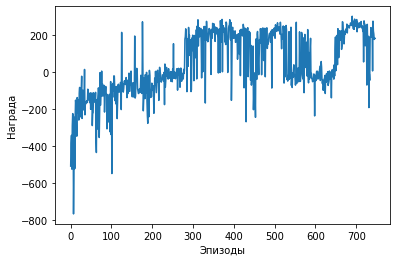

In [3]:
with open('rewards.pickle', 'rb') as f:
    data = pickle.load(f)
    
rewards = data['rewards']
time = len(rewards)
plt.figure()
plt.plot(range(time), rewards)
plt.ylabel('Награда')
plt.xlabel('Эпизоды')
plt.show()

[201.07126808256552]


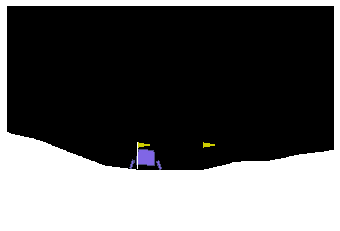

In [9]:
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

rewards = []
avg_rewards = []
reward2break = [100, -100, 10, 200]
eps_params = {'max_eps': 1, 'eps': 1, 'min_eps': 0.05, 'eps_delta': 0.096, 'n_jumps': 10}
agent = QLearningMethod(gamma=0.99, learning_rate=0.0002, batch_size=30, max_memory_len = 1500, tau = 0.001,
                        n_actions=4, n_states=8,
                        eps_settings=eps_params, mode='test') #gamma=0.98, learning_rate=0.0001, batch_size=30, n_actions=4, n_states=8
env = gym.make('LunarLander-v2')
for episod in range(1): #количество эпизодов
    episode_reward = 0
    curr_state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for time_step in range(1000):
        curr_action = agent.choose_action(curr_state)
        img.set_data(env.render(mode='rgb_array'))
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        next_state, curr_reward, done, _ = env.step(curr_action)
        curr_state = next_state
        episode_reward += curr_reward
        if done or curr_reward in reward2break:
            break
    rewards.append(episode_reward)
print(rewards)